In [43]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, 
    TimeSeriesSplit
)
from sklearn.externals import joblib

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from scipy import sparse

from collections import defaultdict
%config InlineBackend.figure_format = 'retina'

In [3]:
def get_summary_grid(grid):
    parms = list(grid.param_grid.keys())
    columns = ['Iter #']
    scorings = grid.scoring
    for scoring in scorings:
        for typ in ['train', 'test']:
            columns.append(f'{typ}_{scoring}')
    columns.extend(['fit_time', 'score_time'])
    for param in grid.param_grid.keys():
        columns.append(param)
    df = pd.DataFrame(columns=columns)
    cv_res = grid.cv_results_
    for col in columns[1:-len(parms)]:
        df[col] = cv_res['mean_' + col]
    items = 1
    for k, v in grid.param_grid.items():
        items *= len(v)
    df['Iter #'] = np.array(range(items)) + 1
    res = defaultdict(list)
    for each in grid.cv_results_['params']:
        for p in parms:
            res[p].append(each[p])
    for k, v in res.items():
        df[k] = v
    return df

In [4]:
def get_summary_randomized(grid):
    parms = list(grid.param_distributions.keys())
    columns = []
    scorings = grid.scoring
    for scoring in scorings:
        for typ in ['train', 'test']:
            columns.append(f'{typ}_{scoring}')
    columns.extend(['fit_time', 'score_time'])
    for param in parms:
        columns.append(param)
    df = pd.DataFrame(columns=columns)
    cv_res = grid.cv_results_
    for col in columns[0:-len(parms)]:
        df[col] = cv_res['mean_' + col]
    items = 1
#     for k, v in grid.param_distributions.items():
#         items *= len(v)
#     df['Iter #'] = np.array(range(items)) + 1
    res = defaultdict(list)
    for each in grid.cv_results_['params']:
        for p in parms:
            res[p].append(each[p])
    for k, v in res.items():
        df[k] = v
    return df

In [5]:
tscv = TimeSeriesSplit(n_splits=5)

## Avg. W2V

In [36]:
Dtrain_Avg_w2v = pd.read_csv('../Amazon_Review_commons/AvgW2V_train.csv')
Dtest_Avg_w2v = pd.read_csv('../Amazon_Review_commons/AvgW2V_test.csv')

In [37]:
print(Dtrain_Avg_w2v.shape)
print(Dtest_Avg_w2v.shape)

(254882, 101)
(109236, 101)


In [38]:
yTrain_avg_w2v = Dtrain_Avg_w2v.Label
yTest_avg_w2v = Dtest_Avg_w2v.Label

Dtrain_Avg_w2v.drop(['Label'], inplace=True, axis=1)
Dtest_Avg_w2v.drop(['Label'], inplace=True, axis=1)

### GridSearch for base learners

In [14]:
params = {
    'max_depth': [2, 4, 6],  # How deep the base learners need to go -- typically small value
    'subsample': [0.5, 0.75, 1.0], # Row sampling like Random Forest 
    'colsample_bytree': [0.3, 0.5, 0.7, 1.0]  # Column sampling like Random Forest
}

In [15]:
estimator = xgb.XGBClassifier(random_state=42)

In [16]:
grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=8)

In [17]:
features = Dtrain_Avg_w2v
labels = yTrain_avg_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

In [ ]:
grid.fit(features, labels)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  6.4min


In [20]:
grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.75)

In [23]:
get_summary_grid(grid).sort_values('test_f1', ascending=False).head()

,Iter #,train_accuracy,test_accuracy,train_f1,test_f1,train_precision,test_precision,train_recall,test_recall,fit_time,score_time,max_depth,subsample,colsample_bytree
25,26,0.919116,0.882462,0.954899,0.933164,0.927105,0.895178,0.984443,0.974519,410.220410,4.100505,6,0.75,0.7
33,34,0.917972,0.882589,0.954240,0.933135,0.926912,0.896359,0.983255,0.973063,484.153447,4.090171,6,0.50,1.0
34,35,0.919868,0.882293,0.955301,0.933029,0.927830,0.895477,0.984483,0.973873,560.638388,3.962929,6,0.75,1.0
16,17,0.917868,0.882053,0.954251,0.932988,0.925627,0.894189,0.984732,0.975310,300.779764,4.086809,6,0.75,0.5
24,25,0.917226,0.882095,0.953859,0.932893,0.925919,0.895678,0.983564,0.973339,350.105640,4.045161,6,0.50,0.7


### GridSearch for overfitting

In [48]:
params = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 150]
}

In [53]:
estimator = grid.best_estimator_

In [54]:
grid2 = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall', 'roc_auc'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=-1)

In [55]:
grid2.fit(features, labels)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 39.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 39.3min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [50, 100, 150]},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score=True,
       scoring={'f1', 'accuracy', 'roc_auc', 'precision', 'recall'},
       verbose=2)

In [56]:
grid2.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [11]:
grid_res = get_summary_grid(grid2)
grid_res.sort_values('test_f1', ascending=False).head()

,Iter #,train_recall,test_recall,train_precision,test_precision,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,train_f1,test_f1,fit_time,score_time,learning_rate,n_estimators
2,3,0.984830,0.971778,0.936630,0.899051,0.928844,0.884374,0.954448,0.895756,0.960106,0.934000,696.867451,8.126419,0.10,150
1,2,0.984443,0.974519,0.927105,0.895178,0.919116,0.882462,0.942089,0.892911,0.954899,0.933164,550.661353,5.652469,0.10,100
0,1,0.987781,0.982276,0.909194,0.882833,0.903486,0.875301,0.918571,0.882082,0.946848,0.929896,323.727481,4.191821,0.10,50
5,6,0.994872,0.992958,0.887916,0.862025,0.886160,0.860207,0.883481,0.859293,0.938338,0.922848,632.175075,7.568961,0.01,150
4,5,0.995750,0.994197,0.885096,0.858806,0.883708,0.857429,0.877199,0.854515,0.937148,0.921527,429.078661,5.367839,0.01,100


In [12]:
sns.set_style("whitegrid")
# grid_res.rename({'min_samples_split': 'min_samples'}, axis=1, inplace=True)

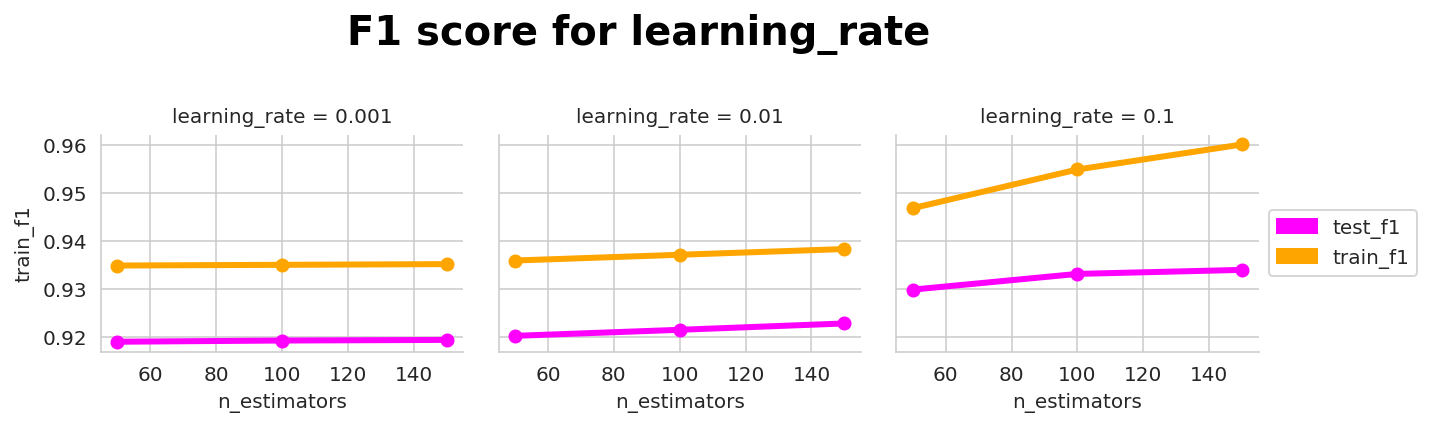

In [24]:
g = sns.FacetGrid(grid_res, col="learning_rate", col_wrap=3, height=3.0)
g = g.map(plt.plot, "n_estimators", "test_f1", marker="o", color='magenta', linewidth=3)
g = g.map(plt.plot, "n_estimators", "train_f1", marker="o", color='orange', linewidth=3)
legend_patches = [matplotlib.patches.Patch(color='magenta', label='test_f1'),
                 matplotlib.patches.Patch(color='orange', label='train_f1')]
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1,0.5))
plt.subplots_adjust(top=0.7)
g.fig.suptitle('F1 score for learning_rate', size=20, weight='bold', color='black');

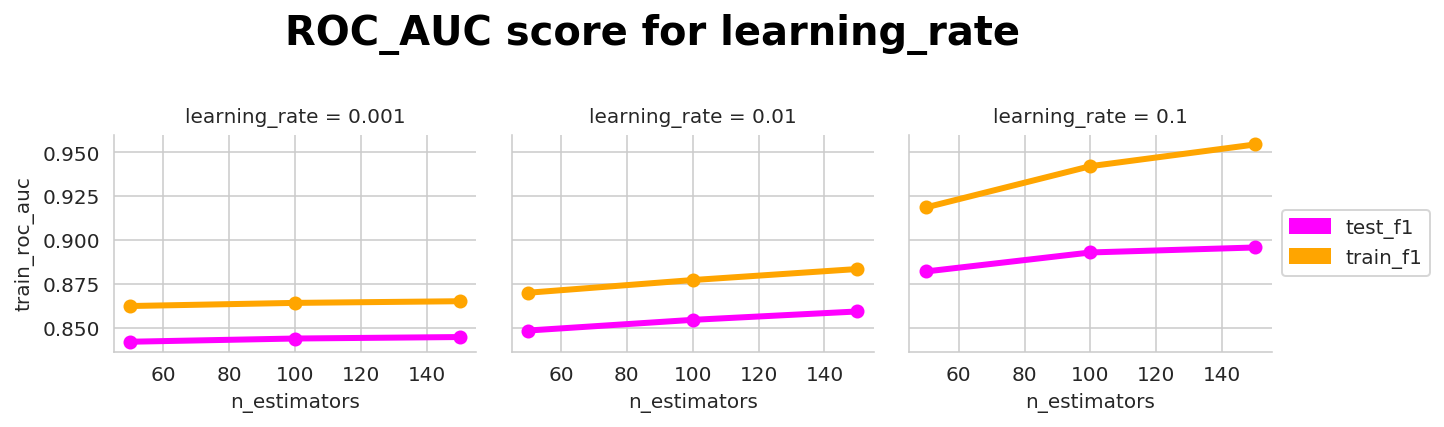

In [26]:
g = sns.FacetGrid(grid_res, col="learning_rate", col_wrap=3, height=3.0)
g = g.map(plt.plot, "n_estimators", "test_roc_auc", marker="o", 
          color='magenta', linewidth=3)
g = g.map(plt.plot, "n_estimators", "train_roc_auc", marker="o", 
          color='orange', linewidth=3)
legend_patches = [matplotlib.patches.Patch(color='magenta', label='test_f1'),
                 matplotlib.patches.Patch(color='orange', label='train_f1')]
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1,0.5))
plt.subplots_adjust(top=0.7)
g.fig.suptitle('ROC_AUC score for learning_rate', 
               size=20, weight='bold', color='black');

In [58]:
estimator = grid2.best_estimator_

### GridSearch for further regularisation

In [59]:
params = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

In [60]:
tscv1 = TimeSeriesSplit(n_splits=2)

In [61]:
grid3 = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall', 'roc_auc'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv1,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=12)

In [ ]:
grid3.fit(features, labels)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   5 out of  10 | elapsed:  8.7min remaining:  8.7min


In [63]:
get_summary_grid(grid3).sort_values('test_f1', ascending=False).head()

,Iter #,train_f1,test_f1,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,train_precision,test_precision,train_recall,test_recall,fit_time,score_time,reg_alpha
1,2,0.958372,0.931681,0.925637,0.881026,0.951325,0.897036,0.933865,0.896051,0.984211,0.970264,687.025945,15.191852,0.01000
0,1,0.958381,0.931616,0.925646,0.880909,0.951401,0.897164,0.933790,0.895951,0.984312,0.970239,686.995831,15.469072,0.00001
2,3,0.958353,0.931600,0.925610,0.880891,0.951599,0.896668,0.933955,0.896011,0.984070,0.970132,686.297859,15.208701,0.10000
3,4,0.957913,0.931438,0.924804,0.880650,0.949969,0.897645,0.933302,0.896142,0.983868,0.969628,688.242452,15.541379,1.00000
4,5,0.943810,0.927940,0.898186,0.873129,0.894848,0.886158,0.908082,0.883615,0.982466,0.976950,579.050534,10.520524,100.00000


The `grid2` best estimator is performing better than `grid3` in terms of `F1 score` probably because of excessive regularisation but may be it would perform better on the test dataset. We shall see.  

### TFIDF W2V

In [6]:
Dtrain_TFIDF_w2v = pd.read_csv('../Amazon_Review_commons/TFIDF_w2v_train.csv')
Dtest_TFIDF_w2v = pd.read_csv('../Amazon_Review_commons/TFIDF_w2v_test.csv')

In [7]:
print(Dtrain_TFIDF_w2v.shape)
print(Dtest_TFIDF_w2v.shape)

(254882, 101)
(109236, 101)


In [8]:
yTrain_tfidf_w2v = Dtrain_TFIDF_w2v.Label
yTest_tfidf_w2v = Dtest_TFIDF_w2v.Label

Dtrain_TFIDF_w2v.drop(['Label'], inplace=True, axis=1)
Dtest_TFIDF_w2v.drop(['Label'], inplace=True, axis=1)

In [14]:
estimator = RandomForestClassifier(random_state=42, n_estimators=50, n_jobs=-1, class_weight='balanced')

In [15]:
params = {
    'max_depth': [10, 12, 15],  # Should be large for high variance
    'min_samples_split': [2, 4, 6]  # Should be fairly low for high variance
}

In [16]:
grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall', 'roc_auc'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=-1)

In [17]:
features = Dtrain_TFIDF_w2v
labels = yTrain_tfidf_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

In [ ]:
grid.fit(features, labels)

In [19]:
get_summary_grid(grid).sort_values('test_f1', ascending=False).head()

,Iter #,train_roc_auc,test_roc_auc,train_f1,test_f1,train_accuracy,test_accuracy,train_recall,test_recall,train_precision,test_precision,fit_time,score_time,max_depth,min_samples_split
6,7,0.994720,0.871280,0.984901,0.925792,0.974196,0.872406,0.972381,0.946508,0.997789,0.906139,81.520724,5.925781,15,2
7,8,0.994492,0.871168,0.984466,0.925270,0.973462,0.871648,0.971773,0.945075,0.997539,0.906455,69.195276,4.834975,15,4
8,9,0.994194,0.871761,0.984104,0.925133,0.972844,0.871549,0.971272,0.944036,0.997322,0.907158,55.332423,3.733296,15,6
3,4,0.977071,0.871820,0.959736,0.913298,0.932351,0.856276,0.932945,0.902522,0.988289,0.924928,79.725405,5.751017,12,2
4,5,0.976525,0.871960,0.959061,0.912954,0.931245,0.855819,0.931931,0.901616,0.988001,0.925212,80.995074,6.077158,12,4


In [20]:
estimator = grid.best_estimator_

In [21]:
params = {
    'max_depth': [15, 18, 20],  # Should be large for high variance
    'min_samples_split': [2]
}

In [22]:
grid2 = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall', 'roc_auc'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=-1)

In [23]:
grid2.fit(features, labels)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  2.0min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [15, 18, 20], 'min_samples_split': [2]},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score=True,
       scoring={'roc_auc', 'f1', 'accuracy', 'recall', 'precision'},
       verbose=2)

In [24]:
get_summary_grid(grid2).sort_values('test_f1', ascending=False).head()

,Iter #,train_roc_auc,test_roc_auc,train_f1,test_f1,train_accuracy,test_accuracy,train_recall,test_recall,train_precision,test_precision,fit_time,score_time,max_depth,min_samples_split
2,3,0.999149,0.868094,0.996032,0.927871,0.993150,0.872646,0.992428,0.973189,0.999667,0.886599,75.514496,4.639139,20,2
1,2,0.998346,0.869320,0.993458,0.927746,0.988736,0.873385,0.987470,0.965867,0.999530,0.892566,88.535750,5.680300,18,2
0,1,0.994720,0.871280,0.984901,0.925792,0.974196,0.872406,0.972381,0.946508,0.997789,0.906139,87.325002,5.539156,15,2


In [25]:
estimator = grid2.best_estimator_

In [26]:
params = {
    'n_estimators': [50, 100, 150, 200],  # Should be fairly large to decrese the overall variance
}

In [27]:
grid3 = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall', 'roc_auc'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=-1)

In [28]:
grid3.fit(features, labels)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  3.8min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  8.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150, 200]},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score=True,
       scoring={'roc_auc', 'f1', 'accuracy', 'recall', 'precision'},
       verbose=2)

In [58]:
grid_res = get_summary_grid(grid3)
grid_res.sort_values('test_f1', ascending=False).head()

,Iter #,train_roc_auc,test_roc_auc,train_f1,test_f1,train_accuracy,test_accuracy,train_recall,test_recall,train_precision,test_precision,fit_time,score_time,n_estimators
3,4,0.999429,0.878869,0.996627,0.928505,0.994180,0.873540,0.993282,0.975510,0.999999,0.885836,221.269544,9.807977,200
2,3,0.999393,0.877650,0.996586,0.928420,0.994109,0.873423,0.993209,0.975175,0.999991,0.885958,241.445727,11.812104,150
1,2,0.999338,0.875369,0.996443,0.928412,0.993861,0.873470,0.992940,0.974687,0.999975,0.886345,194.669477,11.291423,100
0,1,0.999149,0.868094,0.996032,0.927871,0.993150,0.872646,0.992428,0.973189,0.999667,0.886599,109.141599,8.063247,50


In [62]:
gs = grid_res.melt(id_vars=['n_estimators'], value_vars=['test_f1', 'train_f1', 
                                                         'train_roc_auc', 'test_roc_auc'])

gs['type'] = gs.variable.apply(lambda x: 'f1' if 'f1' in x else 'roc_auc')

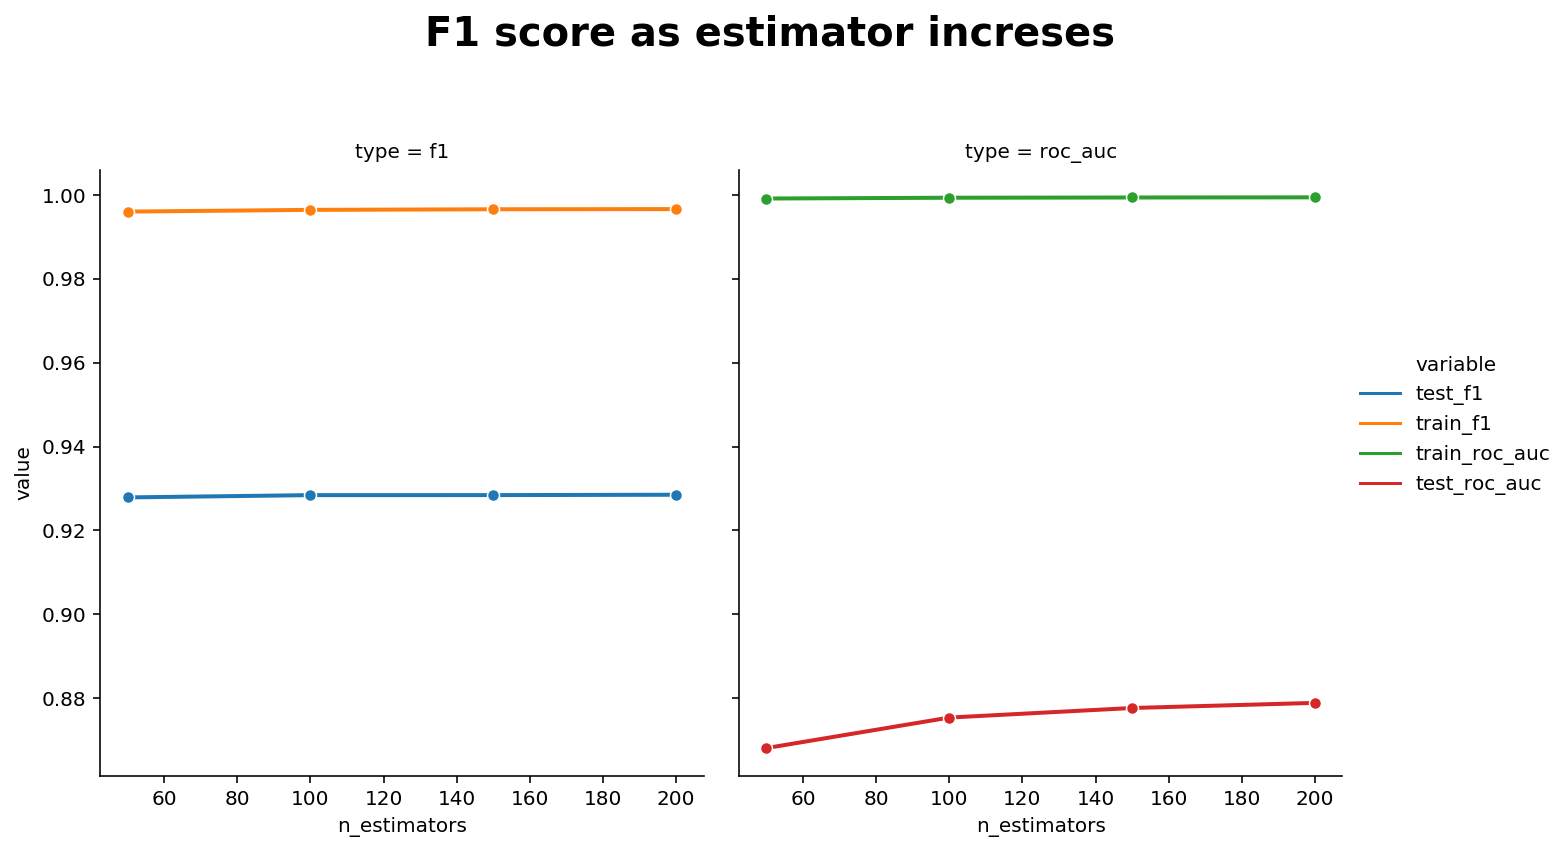

In [63]:
g = sns.relplot(x="n_estimators", y="value",
            hue="variable", col='type',
            color=['orange', 'teal'], data=gs, kind='line',
            height=6, aspect=0.8, lw=2, marker='o'); 
plt.subplots_adjust(top=0.8)
g.fig.suptitle('F1 score as estimator increses', size=20, weight='bold');

The high differenence in the test and training score clearly indicates the overfitting and this means we need more `n_estimators` to reduce the overfitting. Let's incresse the `n_estomators` and see what happens

## Reporting on the test data

In [64]:
!ls

BOW - LightGBM.ipynb   notebook.tex	output_54_0.png  xgb_grid2.grid
bow_lightgbm.model     output_24_0.png	rf_grid3.grid	 xgb_grid3.grid
GBDT + RF - W2V.ipynb  output_25_0.png	rf_grid.grid	 xgb_grid.grid


In [67]:
clf_avg_w2v = joblib.load('xgb_grid3.grid').best_estimator_
clf_tfidf_w2v = joblib.load('rf_grid3.grid').best_estimator_
clf_bow = joblib.load('bow_lightgbm.model')

In [68]:
xTest_avg_w2v = Dtest_Avg_w2v
actuals_avg_w2v = yTest_avg_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

xTest_tfidf_w2v = Dtest_TFIDF_w2v
actuals_tfidf_w2v = yTest_tfidf_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

Dtest_bow = sparse.load_npz('../Amazon_Review_commons/BOW_test.npz')
xTest_bow = Dtest_bow.astype('float64')
Dtest = pd.read_csv('../Amazon_Review_commons/Dtest.csv')
yTest_bow = Dtest.Polarity.apply(lambda x: 1 if x == 'positive' else 0).values
actuals_bow = yTest_bow.astype('float64')

In [69]:
preds_avg_w2v = clf_avg_w2v.predict(xTest_avg_w2v)
preds_tfidf_w2v = clf_tfidf_w2v.predict(xTest_tfidf_w2v)
preds_bow = clf_bow.predict(xTest_bow)

In [70]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

In [71]:
acs_avg_w2v = round(accuracy_score(actuals_avg_w2v, preds_avg_w2v), 5)
acs_tfidf_w2v = round(accuracy_score(actuals_tfidf_w2v, preds_tfidf_w2v), 5)
acs_bow = round(accuracy_score(actuals_bow, preds_bow), 5)

pre_avg_w2v = round(precision_score(actuals_avg_w2v, preds_avg_w2v), 5)
pre_tfidf_w2v = round(precision_score(actuals_tfidf_w2v, preds_tfidf_w2v), 5)
pre_bow = round(precision_score(actuals_bow, preds_bow), 5)

rec_avg_w2v = round(recall_score(actuals_avg_w2v, preds_avg_w2v), 5)
rec_tfidf_w2v = round(recall_score(actuals_tfidf_w2v, preds_tfidf_w2v), 5)
rec_bow = round(recall_score(actuals_bow, preds_bow), 5)

f1_avg_w2v = round(f1_score(actuals_avg_w2v, preds_avg_w2v), 5)
f1_tfidf_w2v = round(f1_score(actuals_tfidf_w2v, preds_tfidf_w2v), 5)
f1_bow = round(f1_score(actuals_bow, preds_bow), 5)

auc_avg_w2v = round(roc_auc_score(actuals_avg_w2v, preds_avg_w2v), 5)
auc_tfidf_w2v = round(roc_auc_score(actuals_tfidf_w2v, preds_tfidf_w2v), 5)
auc_bow = round(roc_auc_score(actuals_bow, preds_bow), 5)

In [72]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ['Vectorization', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
x.add_row(['Avg. W2V', acs_avg_w2v, pre_avg_w2v, rec_avg_w2v, f1_avg_w2v, auc_avg_w2v])
x.add_row(['TFIDF W2V', acs_tfidf_w2v, pre_tfidf_w2v, rec_tfidf_w2v, f1_tfidf_w2v, auc_tfidf_w2v])
x.add_row(['BOW', acs_bow, pre_bow, rec_bow, f1_bow, auc_bow])
print(x)

+---------------+----------+-----------+---------+---------+---------+
| Vectorization | Accuracy | Precision |  Recall |    F1   |   AUC   |
+---------------+----------+-----------+---------+---------+---------+
|    Avg. W2V   | 0.87756  |  0.89415  |  0.966  | 0.92869 | 0.71287 |
|   TFIDF W2V   |  0.8681  |  0.88628  | 0.96386 | 0.92344 | 0.68979 |
|      BOW      | 0.86461  |  0.96193  | 0.87041 | 0.91388 | 0.85379 |
+---------------+----------+-----------+---------+---------+---------+


In [73]:
from sklearn.metrics import confusion_matrix

In [74]:
cm_avg_w2v = pd.DataFrame(confusion_matrix(actuals_avg_w2v, preds_avg_w2v),
             columns=['negative', 'positive'], index=['negative', 'positive'])

cm_tfidf_w2v = pd.DataFrame(confusion_matrix(actuals_tfidf_w2v, preds_tfidf_w2v),
             columns=['negative', 'positive'], index=['negative', 'positive'])

cm_bow = pd.DataFrame(confusion_matrix(actuals_bow, preds_bow),
             columns=['negative', 'positive'], index=['negative', 'positive'])

### Avg. W2V

In [75]:
cm_avg_w2v

,negative,positive
negative,8773,10310
positive,3065,87088


### TFIDF W2v

In [76]:
cm_tfidf_w2v

,negative,positive
negative,7933,11150
positive,3258,86895


### BOW

In [77]:
cm_bow

,negative,positive
negative,15970,3106
positive,11684,78476
